In [1]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
from visual_behavior_glm.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sns.__version__

'0.11.0'

In [4]:
%matplotlib notebook
%widescreen

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [5]:
rs = gat.retrieve_results(search_dict = {'glm_version': '7_L2_optimize_by_session'}, results_type='summary')
rs.sample(10)

_id                   dropout  \
2662067  5f6ebbc64dce009754cc61de            single-running   
1858744  5f6eaea728780d266f906c4b                 omissions   
6099956  5f6f528051992cb07b8a9609             single-change   
2902540  5f6ec0a031d9107d5457e34a              single-pupil   
3900457  5f6ece6309aa7a5e96d03088             single-image6   
2850010  5f6ebf594c99db54e0ece4f6   single-face_motion_PC_0   
3768851  5f6ecc9fc321398fde4f89ff                    misses   
2306906  5f6eb4fb1965926fcc6731e0  single-pupil_and_running   
3911953  5f6ece7609aa7a5e96d04a3c                    image2   
3409348  5f6ec6cb32f5285f151a78be          hits_and_rewards   

         absolute_change_from_full  variance_explained  \
2662067                  -0.024232            0.006391   
1858744                  -0.000092            0.014480   
6099956                  -0.071482            0.002234   
2902540                  -0.038836            0.006348   
3900457                  -0.020098            0.000128   
2850010                  -0.020880            0.002448   
3768851                   0.000065            0.006813   
2306906                   0.001447            0.001447   
3911953                   0.000071            0.016022   
3409348                   0.000136            0.391110   

         variance_explained_full  fraction_change_from_full  cell_specimen_id  \
2662067                 0.030623                  -0.208694        1016953269   
1858744                 0.014571                  -0.006306        1016951171   
6099956                 0.073716                   0.000000         962580174   
2902540                 0.045184                  -0.140483        1016969933   
3900457                 0.020227                   0.000000         962642706   
2850010                 0.023328                   0.000000        1017011946   
3768851                 0.006748                   0.000000         982751916   
2306906                 0.000000                   0.000000         962557205   
3911953                 0.015951                   0.000000         962642322   
3409348                 0.390974                   0.000000        1007949413   

         adj_fraction_change_from_full  adj_variance_explained  \
2662067                      -0.208671                0.006390   
1858744                       0.000000                0.001181   
6099956                      -0.234977                0.014625   
2902540                      -0.140406                0.006346   
3900457                       0.000000                0.001000   
2850010                       0.000000                0.002449   
3768851                       0.000000                0.003117   
2306906                       0.000000                0.001454   
3911953                       0.000000                0.022862   
3409348                       0.000000                0.293024   

         adj_variance_explained_full               glm_version  \
2662067                     0.030623  7_L2_optimize_by_session   
1858744                     0.003534  7_L2_optimize_by_session   
6099956                     0.062238  7_L2_optimize_by_session   
2902540                     0.045201  7_L2_optimize_by_session   
3900457                     0.020097  7_L2_optimize_by_session   
2850010                     0.023319  7_L2_optimize_by_session   
3768851                     0.000374  7_L2_optimize_by_session   
2306906                     0.000000  7_L2_optimize_by_session   
3911953                     0.022608  7_L2_optimize_by_session   
3409348                     0.292430  7_L2_optimize_by_session   

         ophys_experiment_id  ophys_session_id              entry_time_utc  \
2662067            993891833         993790878  2020-09-26 03:55:50.626062   
1858744            978284064         978123903  2020-09-26 02:59:51.273029   
6099956            891994418         891193996  2020-09-26 14:38:56.668679   
2902540            993891832         99

## get a list of columns to use for clustering. Defining this list now makes it easier to avoid accidentally clustering on some identifying feature (e.g., cre_line, session_type, etc.)
I'm removing the 'visual' dropout, since it's actually a combination of the omission and all-images dropouts.

In [6]:
cols_for_clustering = list(rs['dropout'].unique())
cols_for_clustering

['Full',
 'all-images',
 'behavioral',
 'change',
 'change_and_rewards',
 'cognitive',
 'correct_rejects',
 'expectation',
 'face_motion_PC_0',
 'face_motion_PC_1',
 'face_motion_PC_2',
 'face_motion_PC_3',
 'face_motion_PC_4',
 'face_motion_energy',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'omissions',
 'pupil',
 'pupil_and_omissions',
 'pupil_and_running',
 'running',
 'running_and_omissions',
 'single-all-images',
 'single-behavioral',
 'single-change',
 'single-change_and_rewards',
 'single-cognitive',
 'single-correct_rejects',
 'single-expectation',
 'single-face_motion_PC_0',
 'single-face_motion_PC_1',
 'single-face_motion_PC_2',
 'single-face_motion_PC_3',
 'single-face_motion_PC_4',
 'single-face_motion_energy',
 'single-image0',
 'single-image1',
 'single-image2',
 'single-image3',
 'single-image4',
 'single-image5',
 'single-image6',
 'single-image7',
 'single-image_expectation',


## build a pivoted version of the results summary, using the `fraction_change_from_full` column as the values.

In [7]:
rsp = gat.build_pivoted_results_summary(results_summary=rs, cutoff=0.01, value_to_use='adj_fraction_change_from_full')
rsp

identifier  Full  all-images  beh_model  behavioral  \
0      1000743008_1003146172   0.0   -0.124691  -0.002675   -0.247536   
1      1000743008_1003146180   0.0   -0.155498   0.000000    0.000000   
2      1000743008_1003146183   0.0   -0.255117   0.000000   -0.115336   
3      1000743008_1003146186   0.0   -0.344581  -0.002031    0.000000   
4      1000743008_1003146190   0.0   -0.107366  -0.001343   -0.028246   
...                      ...   ...         ...        ...         ...   
55325    995622557_994309976   0.0   -0.399159        NaN    0.000000   
55326    995622557_994309982   0.0   -0.466783        NaN    0.000000   
55327    995622557_994309993   0.0   -0.845850        NaN    0.000000   
55328    995622557_994309997   0.0   -0.470345        NaN    0.000000   
55329    995622557_994310003   0.0   -0.832512        NaN   -0.082732   

         change  change_and_rewards  cognitive  correct_rejects  expectation  \
0     -0.011025           -0.012918  -0.023682         0.000000    -0.058251   
1      0.000000            0.000000  -0.000586         0.000000    -0.072791   
2     -0.009252           -0.011877  -0.014022         0.000000    -0.057735   
3     -0.005703            0.000000  -0.002913        -0.001400    -0.036553   
4     -0.004245           -0.000592  -0.015737         0.000000    -0.060666   
...         ...                 ...        ...              ...          ...   
55325  0.000000            0.000000  -0.020344        -0.034867    -0.082447   
55326  0.000000            0.000000   0.000000         0.000000    -0.085357   
55327  0.000000            0.000000   0.000000         0.000000    -0.025258   
55328  0.000000            0.000000   0.000000         0.000000    -0.083883   
55329 -0.001889           -0.001889  -0.011543        -0.042307    -0.010533   

       face_motion_PC_0  face_motion_PC_1  face_motion_PC_2  face_motion_PC_3  \
0             -0.035958         -0.000712          0.000000          0.000000   
1              0.000000          0.000000          0.000000          0.000000   
2             -0.018408          0.000000          0.000000         -0.006418   
3              0.000000          0.000000         -0.002044          0.000000   
4             -0.017840          0.000000          0.000000          0.000000   
...                 ...               ...               ...               ...   
55325          0.000000          0.000000          0.000000          0.000000   
55326          0.000000          0.000000          0.000000          0.000000   
55327          0.000000          0.000000          0.000000          0.000000   
55328          0.000000          0.000000          0.000000          0.000000   
55329         -0.021263          0.000000         -0.016457          0.000000   

       face_motion_PC_4  face_motion_energy  false_alarms      hits  \
0                   0.0           -0.036169     -0.052731 -0.012233   
1                   0.0            0.000000     -0.190757 -0.005580   
2                   0.0           -0.003291     -0.003304 -0.006527   
3                   0.0           -0.003078      0.000000  0.000000   
4                   0.0            0.000000      0.000000 -0.007470   
...                 ...                 ...           ...       ...   
55325               0.0            0.000000           NaN       NaN   
55326               0.0            0.000000           NaN       NaN   
55327               0.0            0.000000           NaN       NaN   
55328               0.0            0.000000           NaN       NaN   
55329               0.0           -0.031263           NaN       NaN   

       hits_and_rewards    image0    image1    image2    image3    image4  \
0             -0.013254 -0.021102 -0.004661  0.000000 -0.004129 -0.178702   
1              0.000000  0.000000 -0.009054 -0.042459 -0.099228 -0.046131   
2             -0.004878 -0.276427 -0.453462 -0.187474 -0.000505  0.000000   
3              0.000000  0.000000 -0.011183 -0

In [8]:
rsp[cols_for_clustering].fillna(0)

Full  all-images  behavioral    change  change_and_rewards  cognitive  \
0       0.0   -0.124691   -0.247536 -0.011025           -0.012918  -0.023682   
1       0.0   -0.155498    0.000000  0.000000            0.000000  -0.000586   
2       0.0   -0.255117   -0.115336 -0.009252           -0.011877  -0.014022   
3       0.0   -0.344581    0.000000 -0.005703            0.000000  -0.002913   
4       0.0   -0.107366   -0.028246 -0.004245           -0.000592  -0.015737   
...     ...         ...         ...       ...                 ...        ...   
55325   0.0   -0.399159    0.000000  0.000000            0.000000  -0.020344   
55326   0.0   -0.466783    0.000000  0.000000            0.000000   0.000000   
55327   0.0   -0.845850    0.000000  0.000000            0.000000   0.000000   
55328   0.0   -0.470345    0.000000  0.000000            0.000000   0.000000   
55329   0.0   -0.832512   -0.082732 -0.001889           -0.001889  -0.011543   

       correct_rejects  expectation  face_motion_PC_0  face_motion_PC_1  \
0             0.000000    -0.058251         -0.035958         -0.000712   
1             0.000000    -0.072791          0.000000          0.000000   
2             0.000000    -0.057735         -0.018408          0.000000   
3            -0.001400    -0.036553          0.000000          0.000000   
4             0.000000    -0.060666         -0.017840          0.000000   
...                ...          ...               ...               ...   
55325        -0.034867    -0.082447          0.000000          0.000000   
55326         0.000000    -0.085357          0.000000          0.000000   
55327         0.000000    -0.025258          0.000000          0.000000   
55328         0.000000    -0.083883          0.000000          0.000000   
55329        -0.042307    -0.010533         -0.021263          0.000000   

       face_motion_PC_2  face_motion_PC_3  face_motion_PC_4  \
0              0.000000          0.000000               0.0   
1              0.000000          0.000000               0.0   
2              0.000000         -0.006418               0.0   
3             -0.002044          0.000000               0.0   
4              0.000000          0.000000               0.0   
...                 ...               ...               ...   
55325          0.000000          0.000000               0.0   
55326          0.000000          0.000000               0.0   
55327          0.000000          0.000000               0.0   
55328          0.000000          0.000000               0.0   
55329         -0.016457          0.000000               0.0   

       face_motion_energy    image0    image1    image2    image3    image4  \
0               -0.036169 -0.021102 -0.004661  0.000000 -0.004129 -0.178702   
1                0.000000  0.000000 -0.009054 -0.042459 -0.099228 -0.046131   
2               -0.003291 -0.276427 -0.453462 -0.187474 -0.000505  0.000000   
3               -0.003078  0.000000 -0.011183 -0.017174 -0.177463 -0.287611   
4                0.000000 -0.218472 -0.041329  0.000000 -0.179483  0.000000   
...                   ...       ...       ...       ...       ...       ...   
55325            0.000000 -0.148046  0.000000 -0.272360  0.000000  0.000000   
55326            0.000000 -0.288185  0.000000 -0.026604  0.000000  0.000000   
55327            0.000000  0.000000  0.000000 -0.370175  0.000000  0.000000   
55328            0.000000 -0.123467 -0.088974  0.000000  0.000000  0.000000   
55329           -0.031263  0.000000 -0.829208 -0.132138 -0.833223 -0.967287   

         image5    image6    image7  image_expectation  intercept    misses  \
0     -0.033314 -0.145868 -0.033082          -0.017764  -0.001074 -0.057593   
1     -0.158902 -0.165947 -0.142046          -0.037831   0.000000  0.000000   
2      0.000000  0.000000 -0.163416          -0.022009  -0.003281  0.000000   
3     -0.158758 -1.000000  0.000000          -0.012837   0.000000  0.000000   
4     -0.033268 -0.080902  0.000000         

# Dimensionality reduction and clustering
So many more things to try here. This is just a start.

## PCA

In [9]:
n_components = 40
pca = gat.run_pca(
    rsp[cols_for_clustering],
    n_components=n_components
)
for pc in range(n_components):
    rsp['pc_{}'.format(pc)] = pca.results[:,pc]

<IPython.core.display.Javascript object>


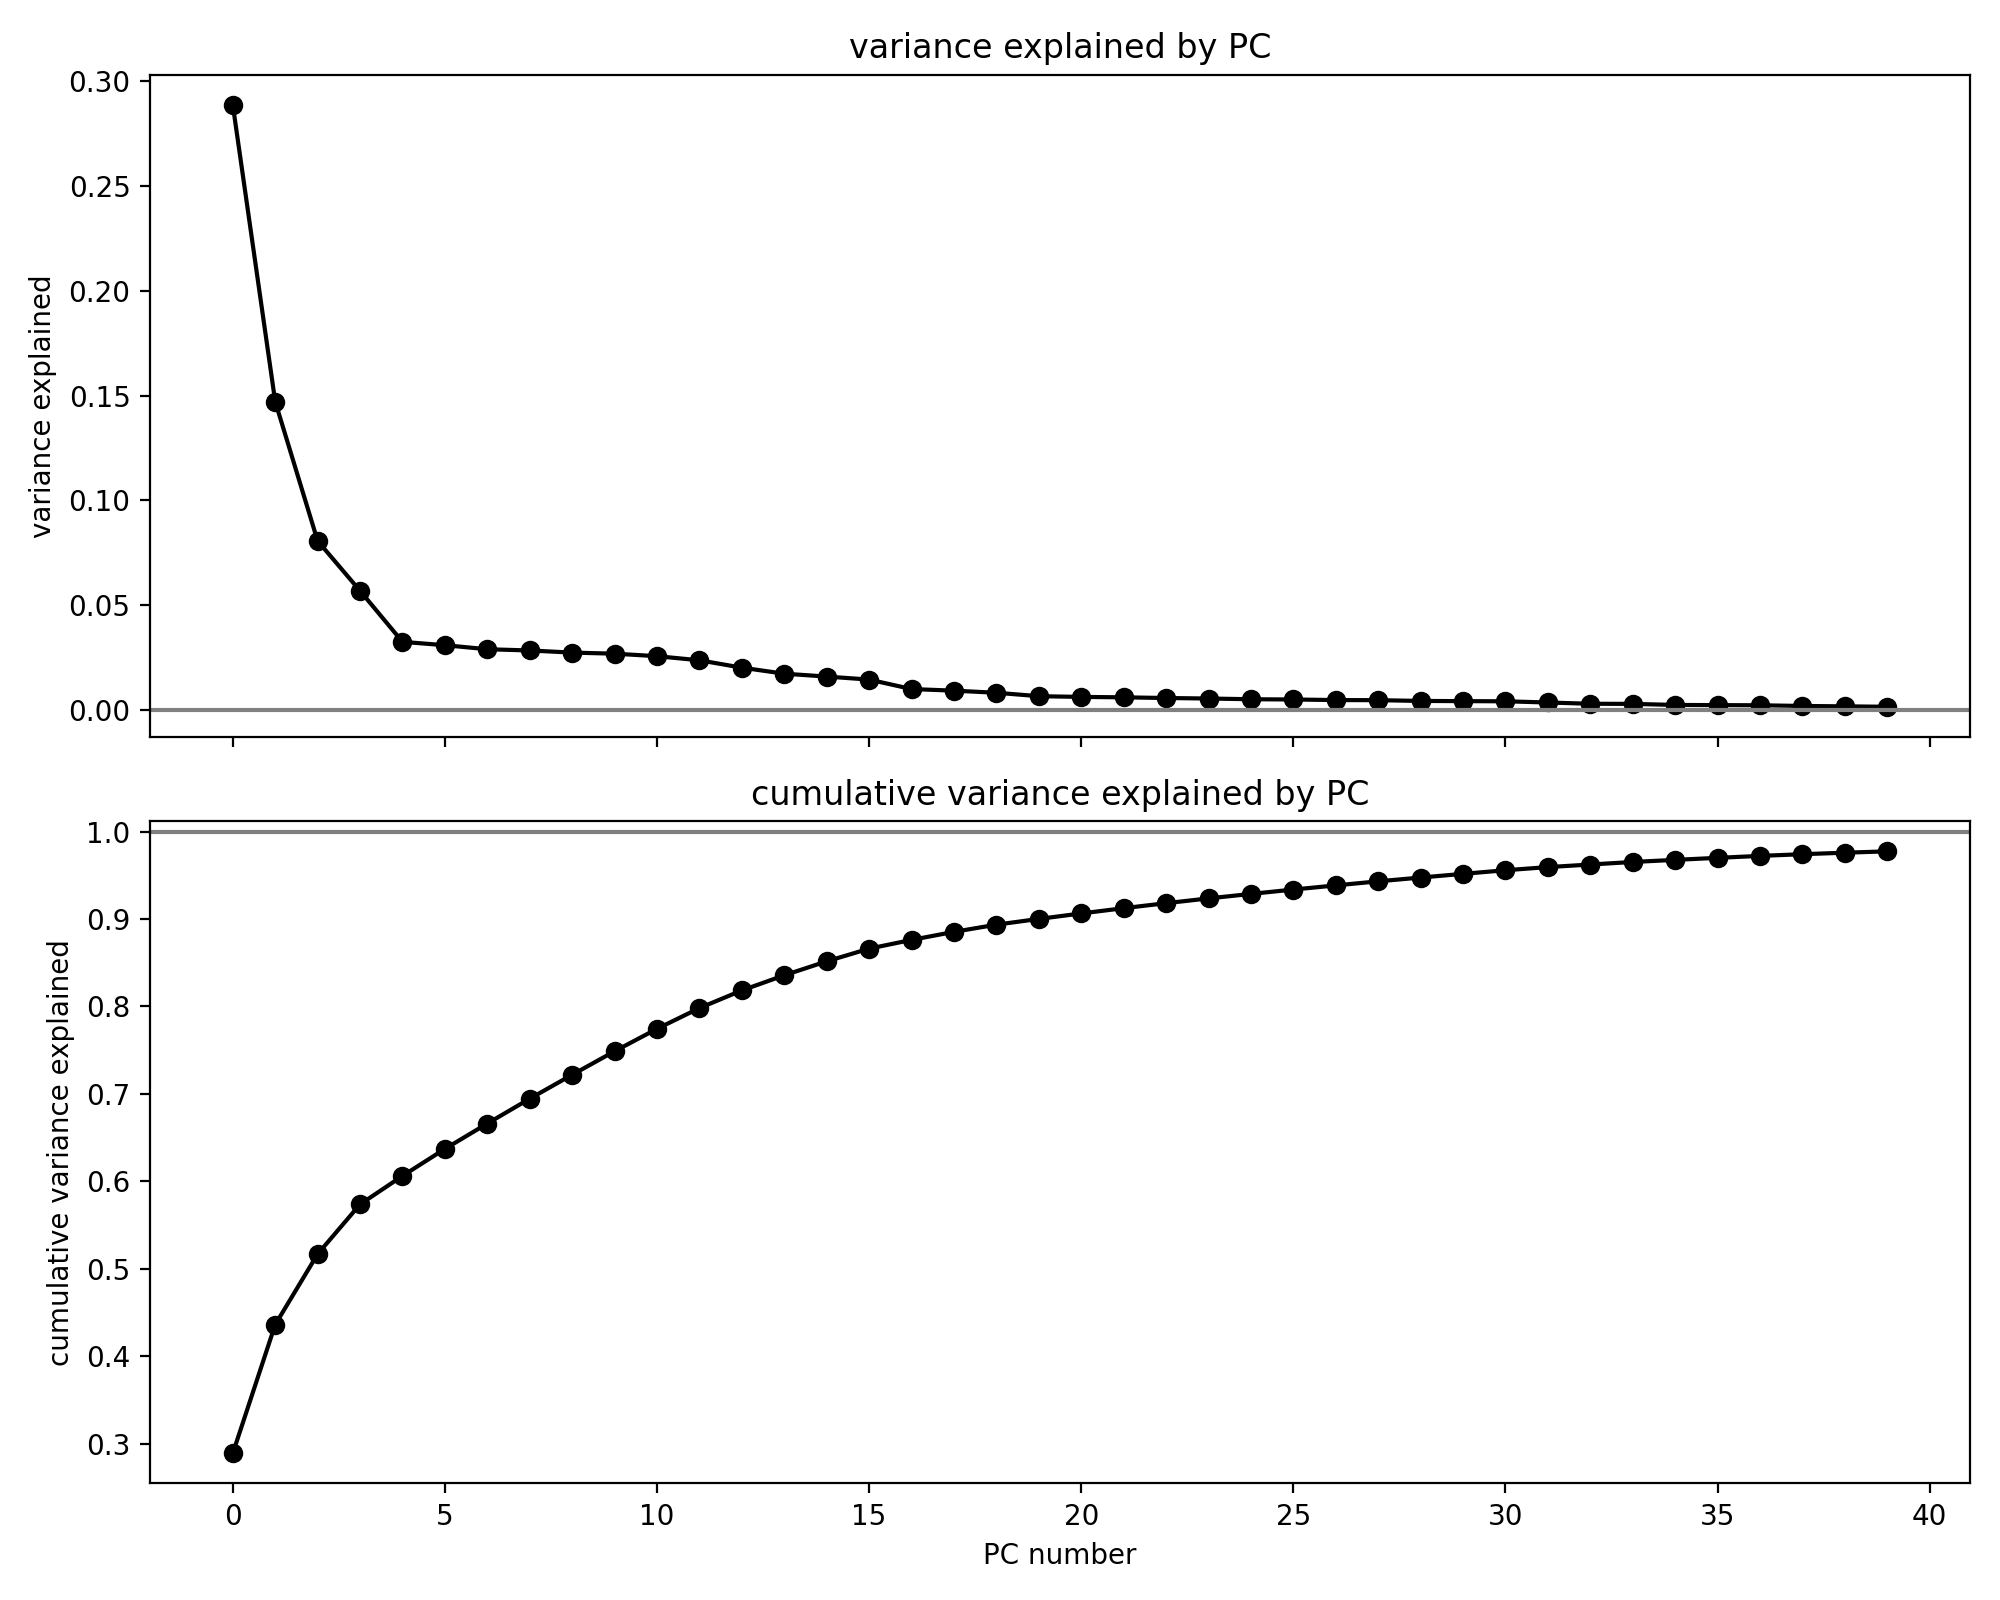

In [10]:
fig,ax = gvt.plot_PCA_var_explained(pca)

<IPython.core.display.Javascript object>


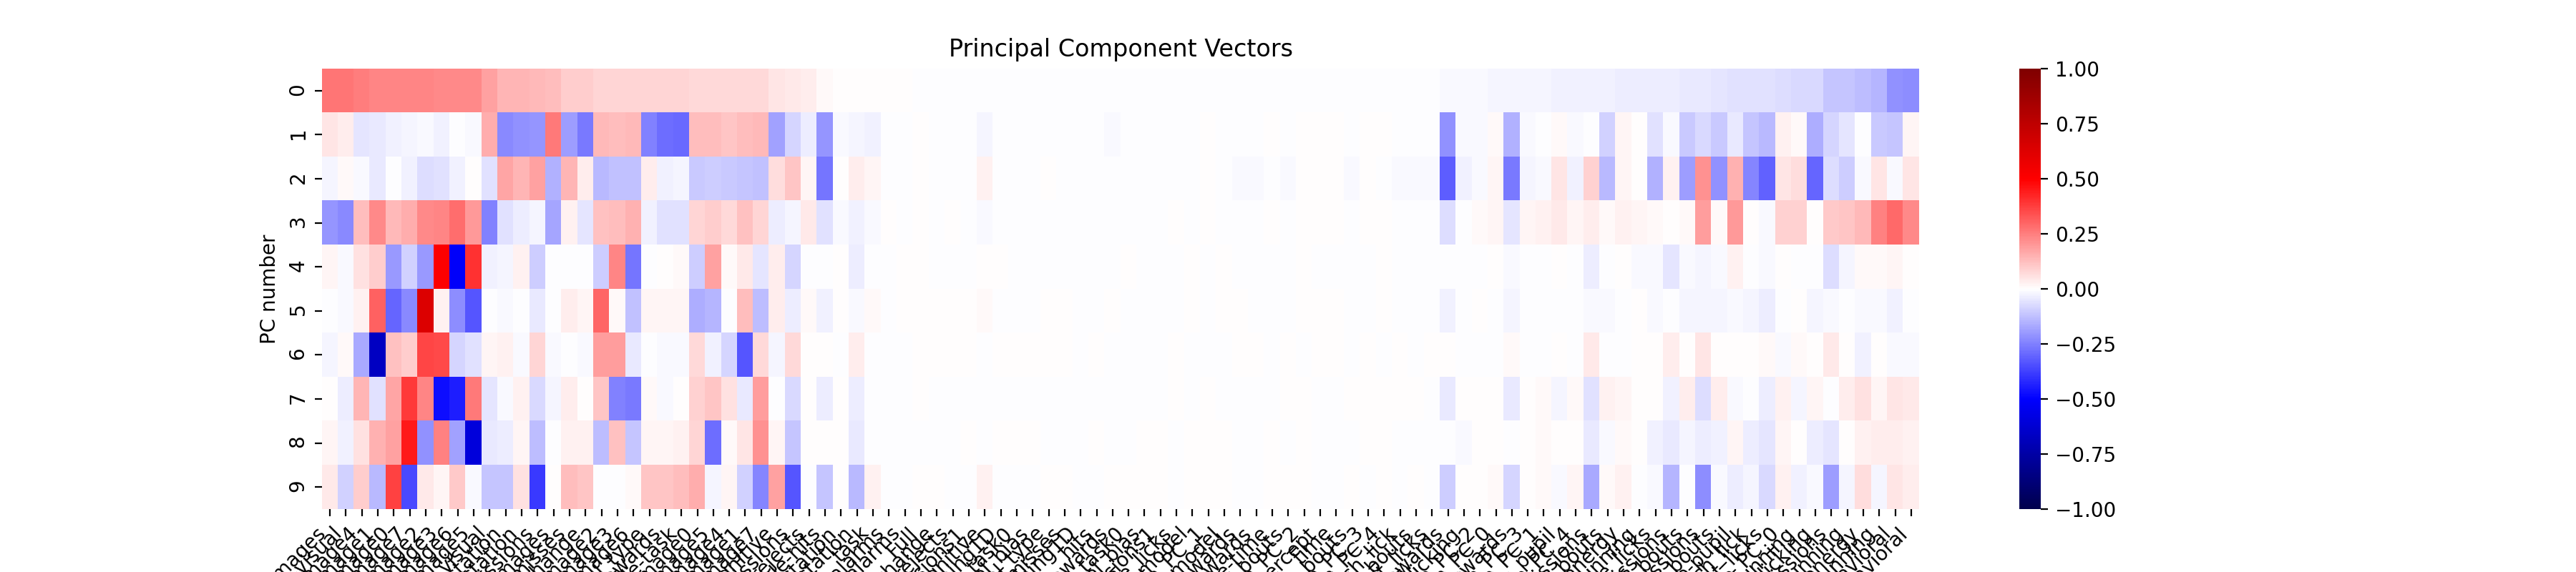

In [45]:
gvt.pc_component_heatmap(pca)

In [22]:
rsp['cre_line'].dropna().unique()

array(['Sst-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Vip-IRES-Cre'], dtype=object)

<IPython.core.display.Javascript object>


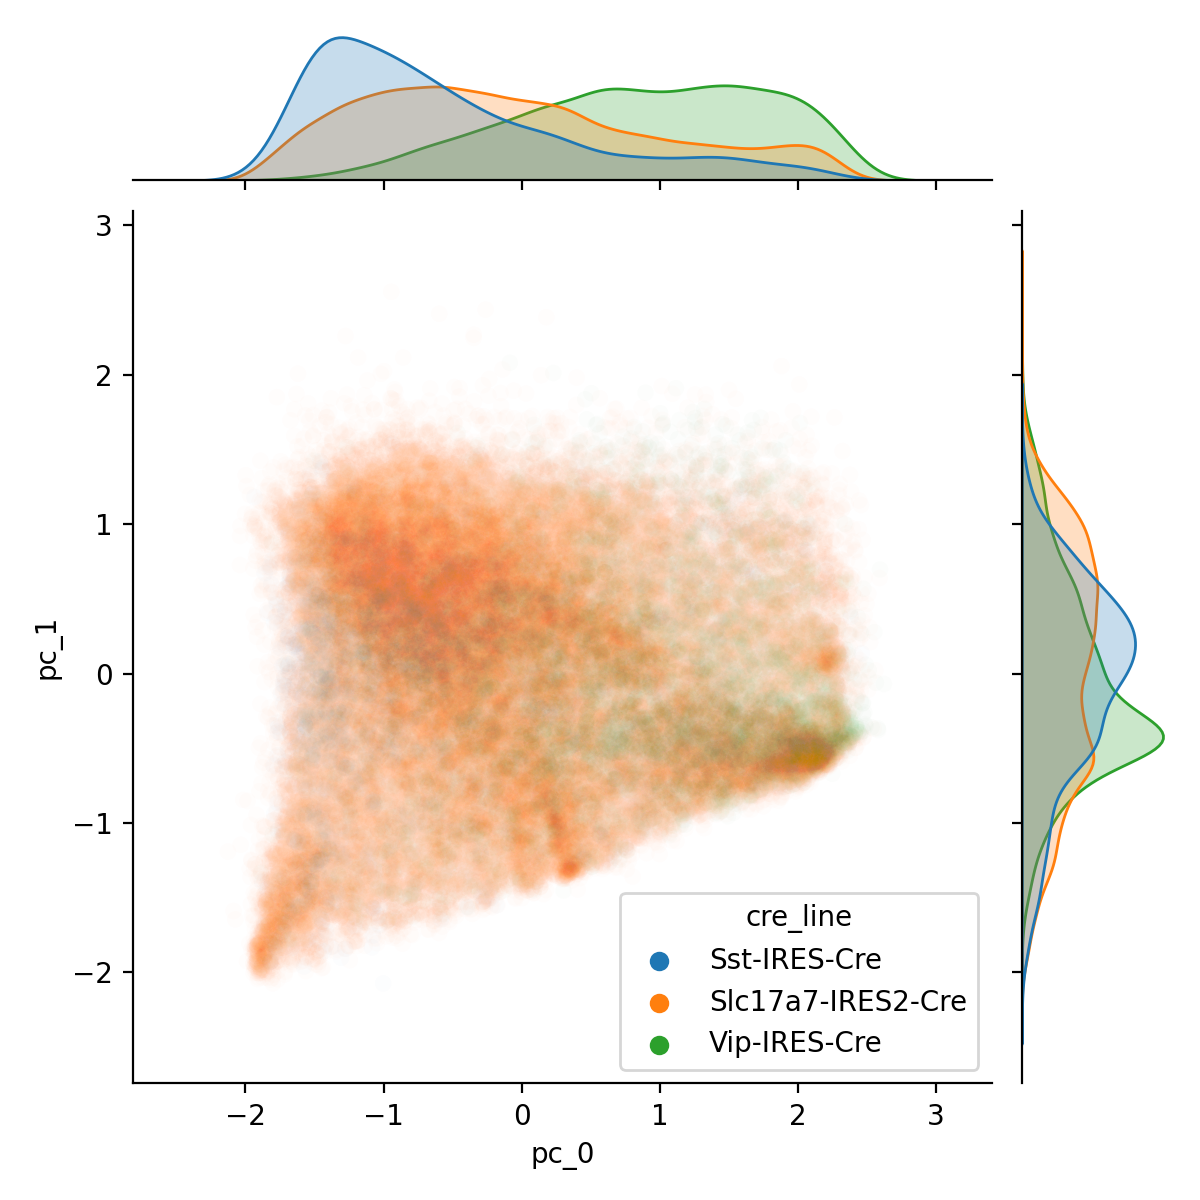

In [25]:
g = sns.jointplot(
    x="pc_0", 
    y="pc_1", 
    data=rsp,
    hue='cre_line',
    hue_order=rsp['cre_line'].dropna().unique(),
    alpha=0.01,
    marginal_kws={'common_norm':False}
)

<IPython.core.display.Javascript object>


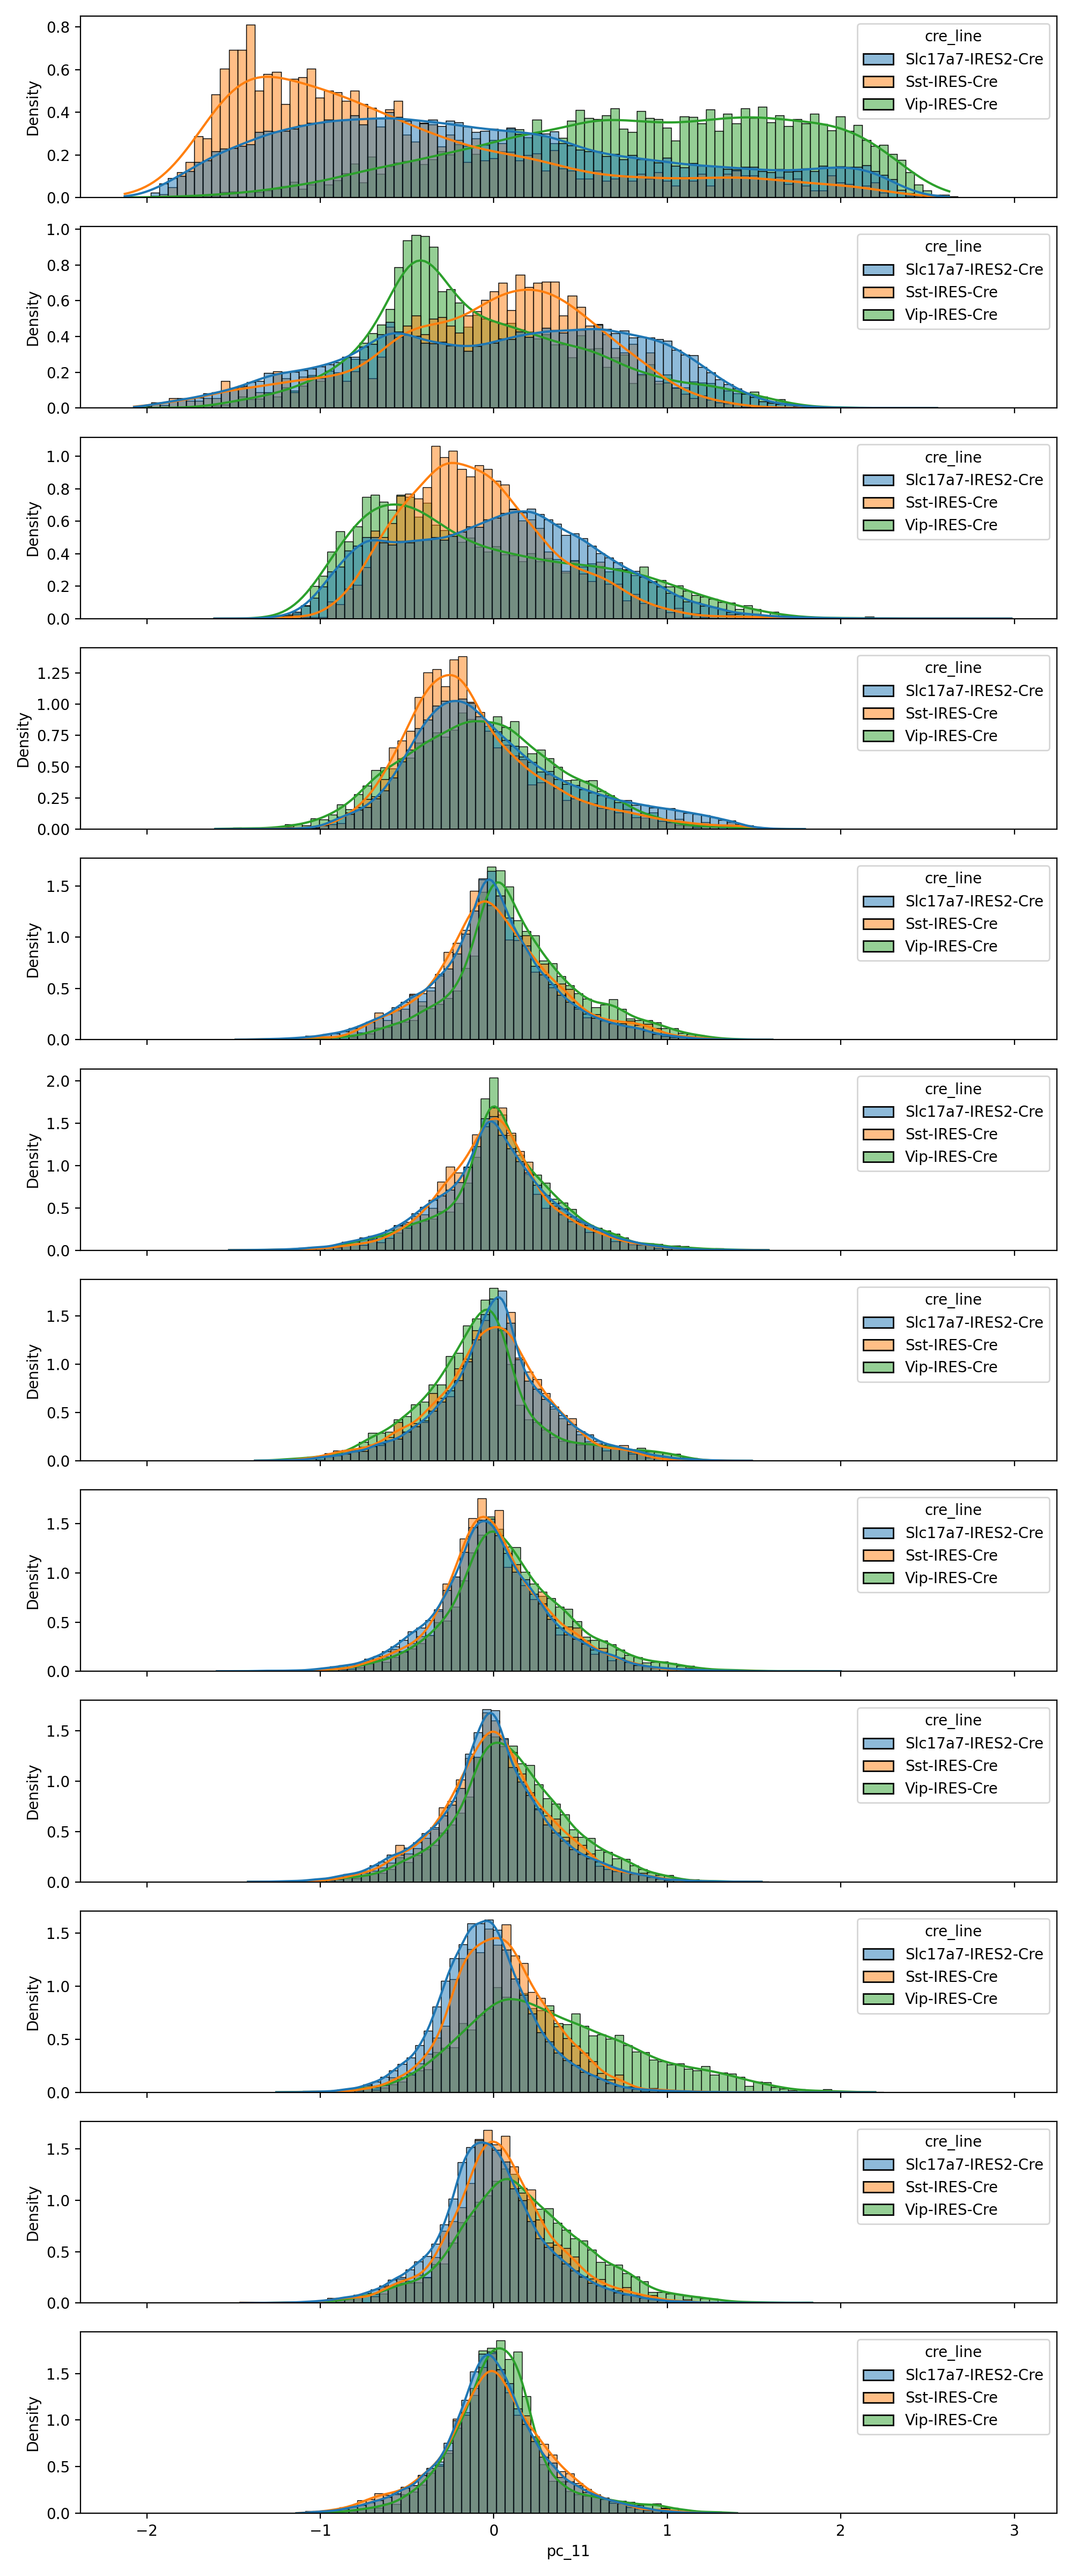

In [27]:
n_pcs_to_plot = 12
fig,ax=plt.subplots(n_pcs_to_plot,1,sharex=True,figsize=(10,2*n_pcs_to_plot))
for pc in range(n_pcs_to_plot):
    sns.histplot(
        rsp, 
        x='pc_{}'.format(pc),
        hue='cre_line',
        hue_order = np.sort(rsp['cre_line'].dropna().unique()),
        binwidth=0.05,
        ax = ax[pc],
        stat='density',
        kde=True,
        common_norm=False,
    )
fig.tight_layout()

In [37]:
from importlib import reload
reload(gvt)

<module 'visual_behavior_glm.GLM_visualization_tools' from '/home/dougo/Code/visual_behavior_glm/visual_behavior_glm/GLM_visualization_tools.py'>

<IPython.core.display.Javascript object>


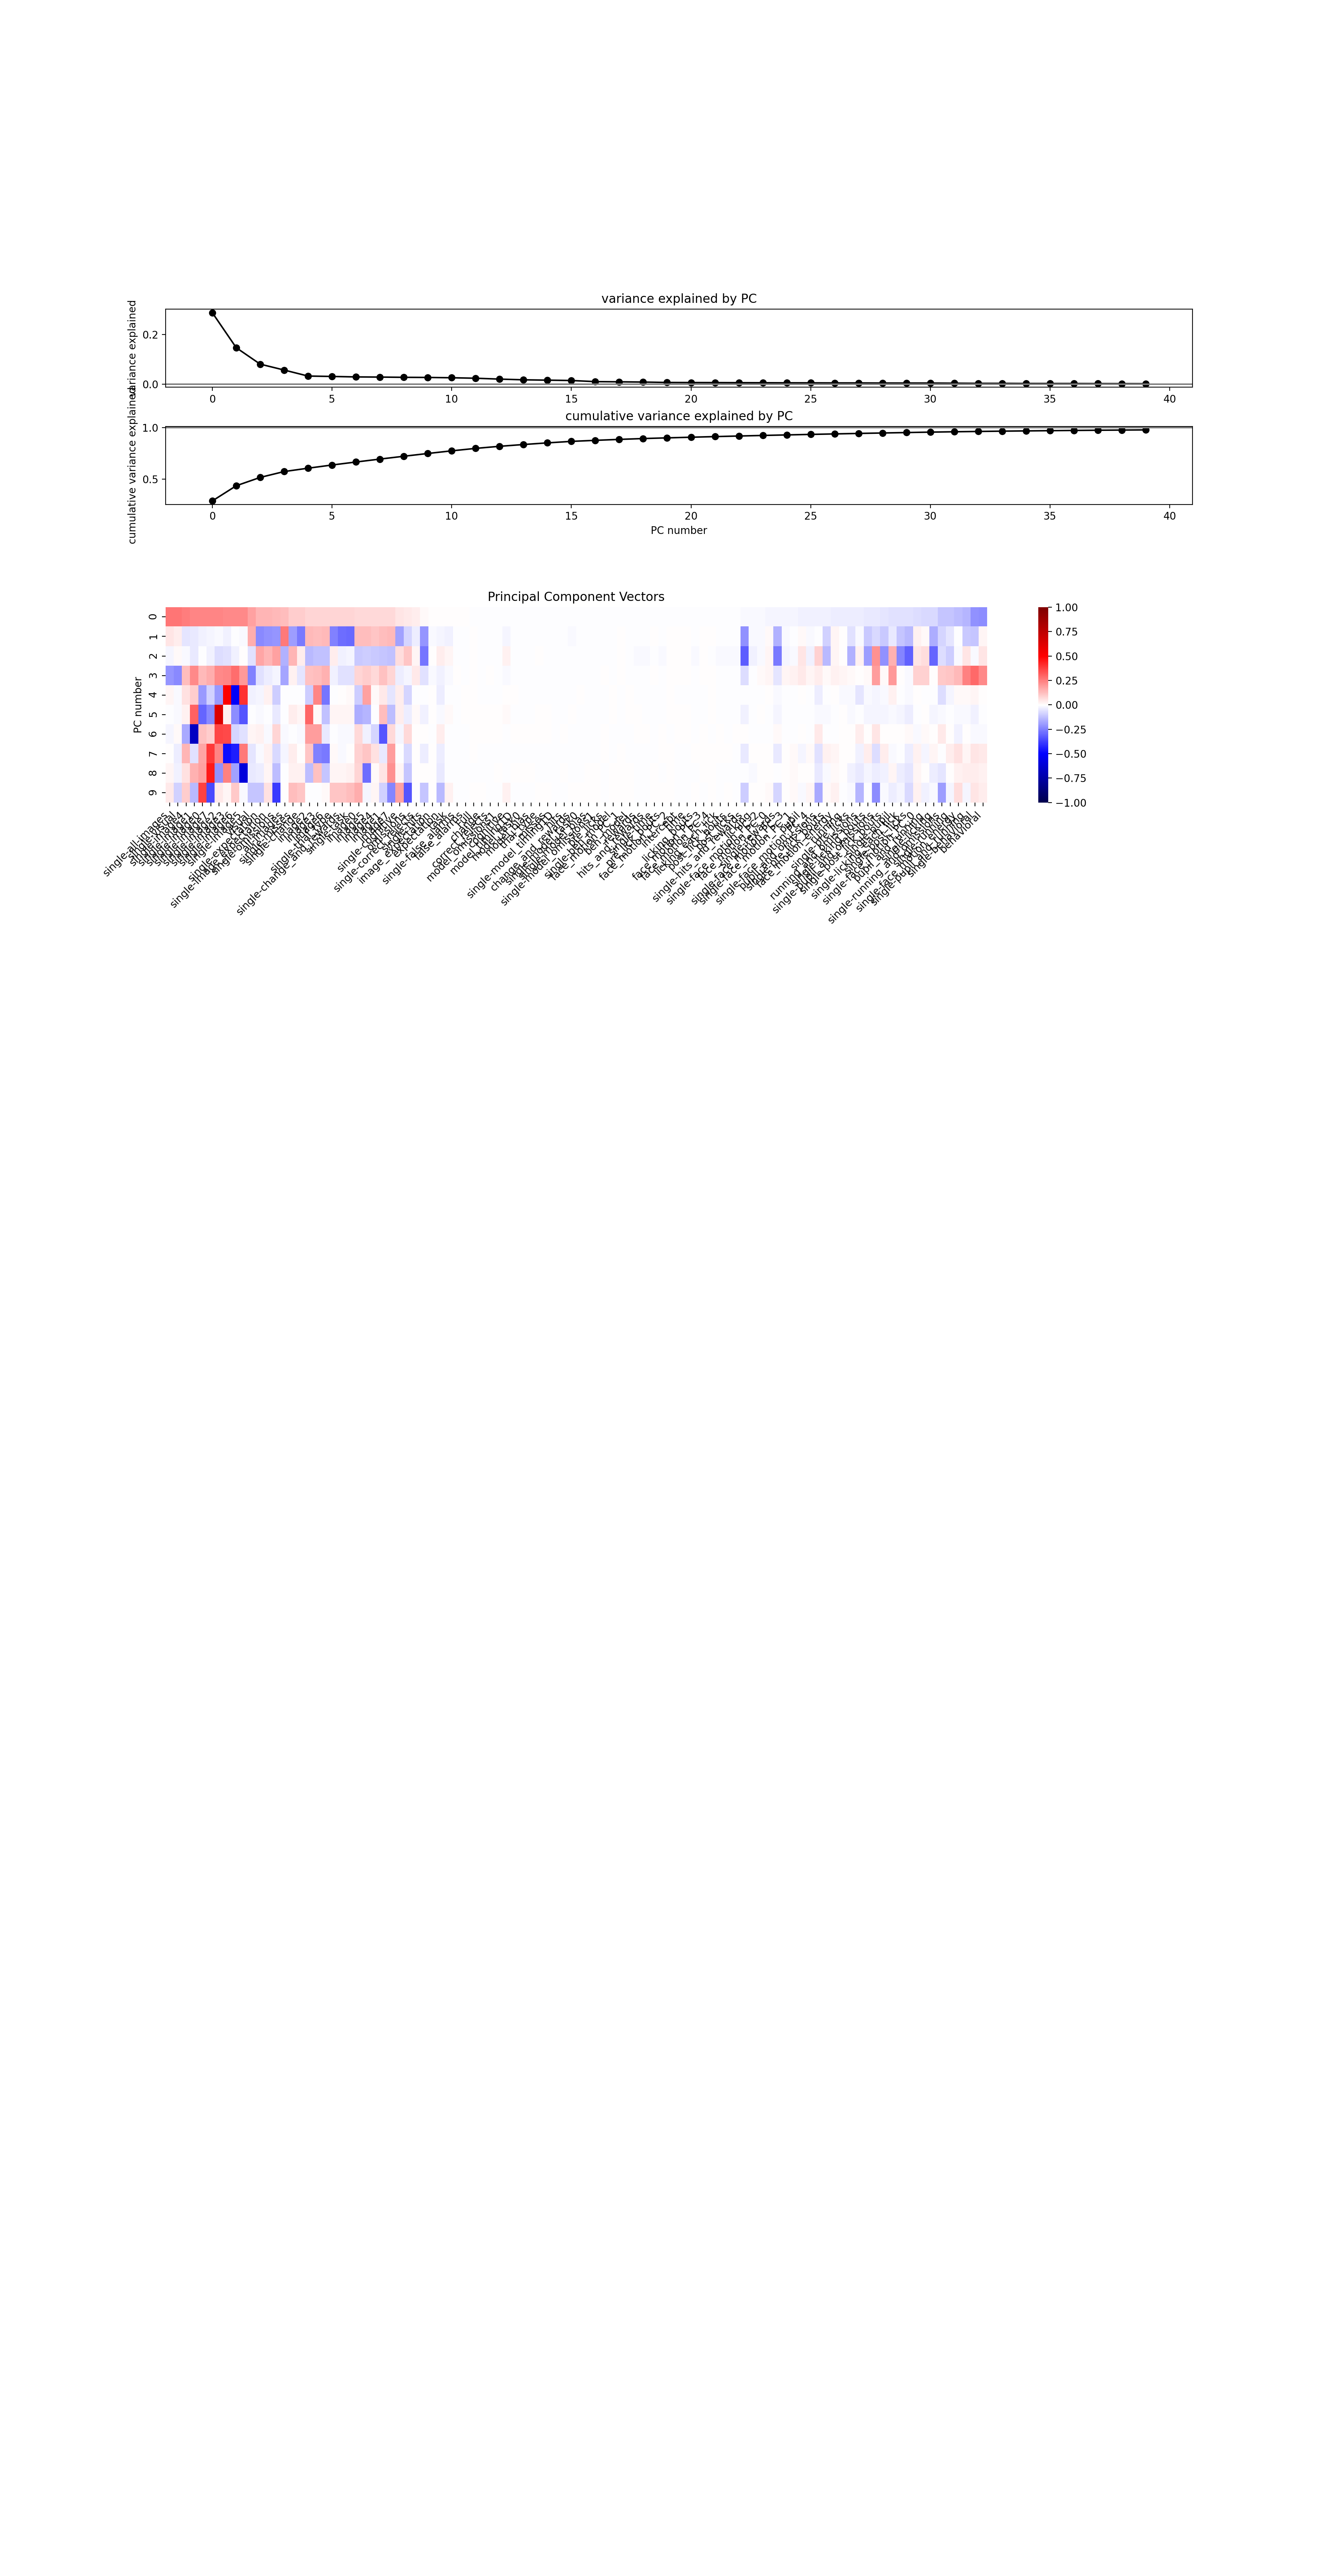

In [51]:
fig = plt.figure(figsize=(18,35))
axes = {
    'var_explained':vbp.placeAxesOnGrid(fig, xspan=[0,1], yspan=[0,0.1], dim=(2,1),hspace=0.5),
    'pc_heatmap':vbp.placeAxesOnGrid(fig, xspan=[0,1], yspan=[0.15, 0.25], wspace=0.5),
}

gvt.plot_PCA_var_explained(pca, axes['var_explained'])
gvt.pc_component_heatmap(pca, axes['pc_heatmap'])